In [3]:
import torch
import traceback
import torch_scatter
import yaml
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
import random
sys.path.append('/mnt/weka/scratch/yang.liu3/pyworkspace/3DGS')

import open3d.ml.torch as ml3d
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from torch import nn
from scene import Scene, LargeScene
from scene.datasets import GSDataset
from gaussian_renderer import render, render_v2
from utils.general_utils import safe_state
from argparse import ArgumentParser
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams
from utils.loss_utils import l1_loss, ssim
from utils.camera_utils import loadCam
from utils.general_utils import build_rotation, build_symmetric
from pytorch3d.transforms import matrix_to_quaternion

In [4]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

In [7]:
config = '../config/lod_mc_aerial_block9_vox1_avg.yaml'
iteration = 15_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
# lp.block_id = 9
lp.source_path = os.path.join("../", lp.source_path)
lp.pretrain_path = os.path.join("../", lp.pretrain_path)
lp.model_path = os.path.join("../output/", config_name)

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    # scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    scene = LargeScene(lp, gaussians, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {lp.model_path}\n')

Reading camera 1689/1689
Loaded ../output/lod_mc_aerial_block9_vox1_avg



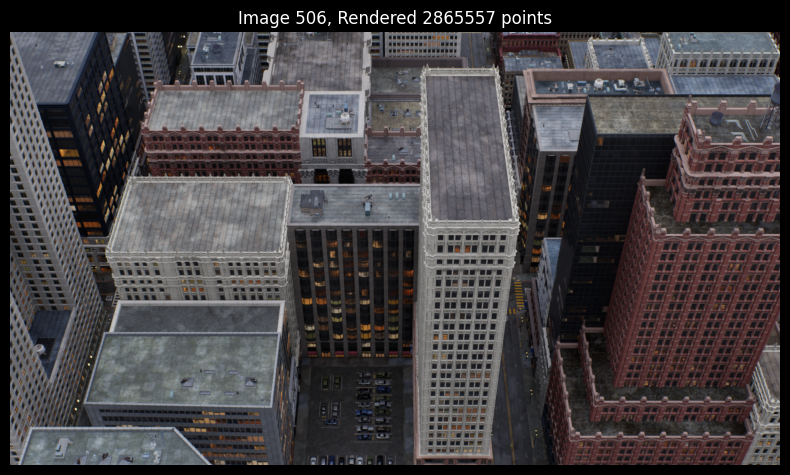

In [8]:
# for cell 9 in block 9, the avg loss is 0.0593
with torch.no_grad():
    idx = random.randint(0, len(gs_dataset)-1)
    # idx = 35

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    # render_pkg = render_v2(cam_info, masked_gaussians, pp, background)
    image = render_pkg["render"]

    gt_image = gt_image.cpu().numpy().transpose(1,2,0)
    image = image.cpu().numpy().transpose(1,2,0)

    plt.figure(figsize=(8, 8))
    plt.imshow(gt_image)
    plt.title(f"Image {idx}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

In [8]:
test_block_id = 0
block_dim = [4, 4, 1]

In [9]:
plt.figure()
plt.style.use('seaborn-white')

block_id_z = test_block_id // (block_dim[0] * block_dim[1])
block_id_y = (test_block_id % (block_dim[0] * block_dim[1])) // block_dim[0]
block_id_x = (test_block_id % (block_dim[0] * block_dim[1])) % block_dim[0]

xyz = gaussians.get_xyz
min_x = lp.aabb[0] + (lp.aabb[3] - lp.aabb[0]) * float(block_id_x) / block_dim[0]
max_x = lp.aabb[0] + (lp.aabb[3] - lp.aabb[0]) * float(block_id_x + 1) / block_dim[0]
min_y = lp.aabb[1] + (lp.aabb[4] - lp.aabb[1]) * float(block_id_y) / block_dim[1]
max_y = lp.aabb[1] + (lp.aabb[4] - lp.aabb[1]) * float(block_id_y + 1) / block_dim[1]
min_z = lp.aabb[2] + (lp.aabb[5] - lp.aabb[2]) * float(block_id_z) / block_dim[2]
max_z = lp.aabb[2] + (lp.aabb[5] - lp.aabb[2]) * float(block_id_z + 1) / block_dim[2]

plt.scatter(gaussians.get_xyz[::100, 0].detach().cpu(), gaussians.get_xyz[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
plt.plot([min_x, max_x], [min_y, min_y], c='b')
plt.plot([min_x, max_x], [max_y, max_y], c='b')
plt.plot([min_x, min_x], [min_y, max_y], c='b')
plt.plot([max_x, max_x], [min_y, max_y], c='b')
# plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

test_block_id += 1

AttributeError: 'GroupParams' object has no attribute 'aabb'

<Figure size 640x480 with 0 Axes>

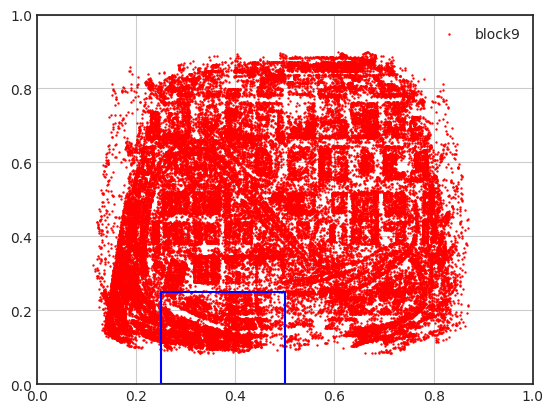

In [10]:
xy_range = [-5, 0, 5, 4]
with torch.no_grad():
    xyz_org = gaussians.get_xyz
    aabb = torch.tensor([xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                         xy_range[2], xy_range[3], xyz_org[:, -1].max()], device='cuda')
    xyz_contracted = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

test_block_id += 1
block_id_z = test_block_id // (block_dim[0] * block_dim[1])
block_id_y = (test_block_id % (block_dim[0] * block_dim[1])) // block_dim[1]
block_id_x = (test_block_id % (block_dim[0] * block_dim[1])) % block_dim[1]

min_x, max_x = float(block_id_x) / block_dim[0], float(block_id_x + 1) / block_dim[0]
min_y, max_y = float(block_id_y) / block_dim[1], float(block_id_y + 1) / block_dim[1]
min_z, max_z = float(block_id_z) / block_dim[2], float(block_id_z + 1) / block_dim[2]

block_mask = (xyz_contracted[:, 0] >= min_x) & (xyz[:, 0] < max_x)  \
            & (xyz_contracted[:, 1] >= min_y) & (xyz[:, 1] < max_y) \
            & (xyz_contracted[:, 2] >= min_z) & (xyz[:, 2] < max_z)

plt.scatter(xyz_contracted[::100, 0].detach().cpu(), xyz_contracted[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
plt.plot([min_x, max_x], [min_y, min_y], c='b')
plt.plot([min_x, max_x], [max_y, max_y], c='b')
plt.plot([min_x, min_x], [min_y, max_y], c='b')
plt.plot([max_x, max_x], [min_y, max_y], c='b')
# plt.axis('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
xyz_org = gaussians.get_xyz

sh_degree = gaussians.max_sh_degree
masked_gaussians = GaussianModel(sh_degree)
masked_gaussians._xyz = xyz_org[block_mask]
masked_gaussians._scaling = gaussians._scaling[block_mask]
masked_gaussians._rotation = gaussians._rotation[block_mask]
masked_gaussians._features_dc = gaussians._features_dc[block_mask]
masked_gaussians._features_rest = gaussians._features_rest[block_mask]
masked_gaussians._opacity = gaussians._opacity[block_mask]
masked_gaussians.max_radii2D = gaussians.max_radii2D[block_mask]

  0%|          | 0/1689 [00:00<?, ?it/s]

[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1


  2%|▏         | 32/1689 [00:05<04:27,  6.20it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


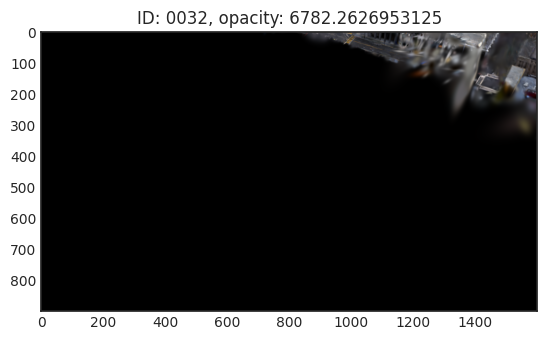

  2%|▏         | 41/1689 [00:07<04:49,  5.69it/s]

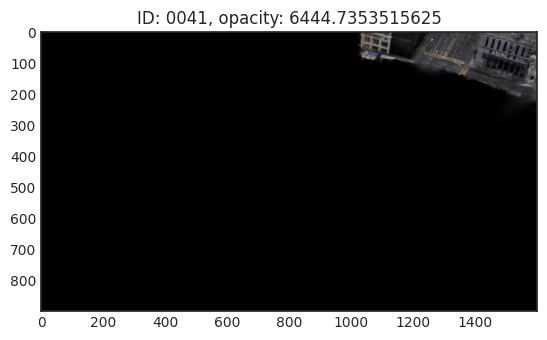

  2%|▏         | 42/1689 [00:08<07:35,  3.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


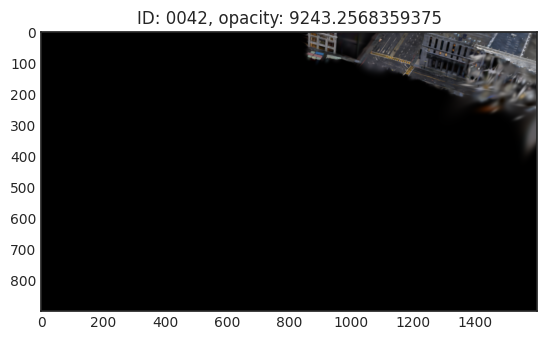

  3%|▎         | 43/1689 [00:08<09:39,  2.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


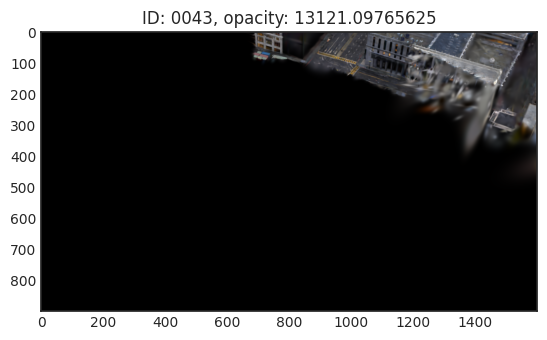

  3%|▎         | 52/1689 [00:10<05:22,  5.08it/s]

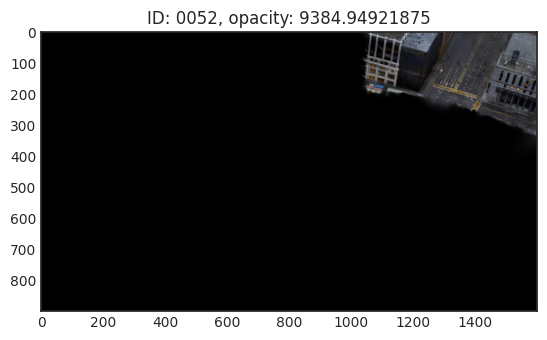

  3%|▎         | 53/1689 [00:11<08:06,  3.36it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


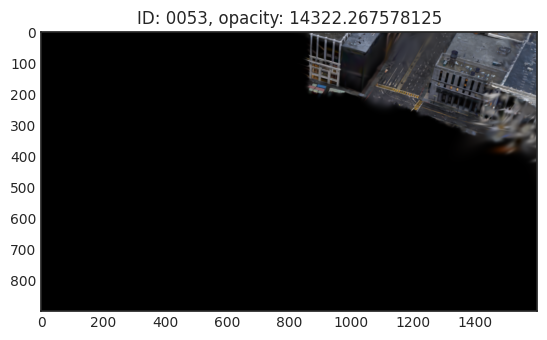

  3%|▎         | 54/1689 [00:11<10:03,  2.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


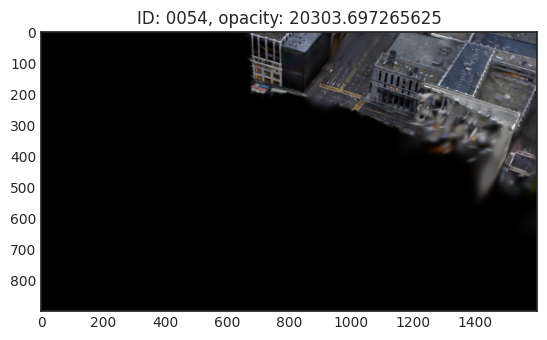

  4%|▎         | 61/1689 [00:13<05:37,  4.82it/s]

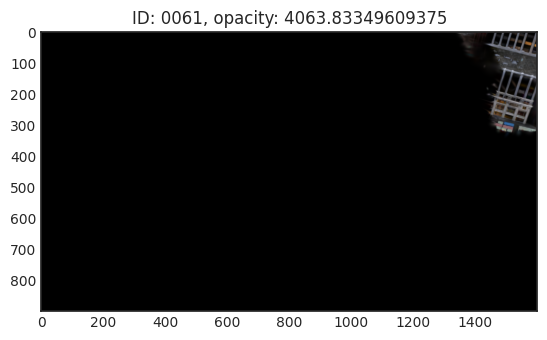

  4%|▎         | 62/1689 [00:13<08:06,  3.35it/s]

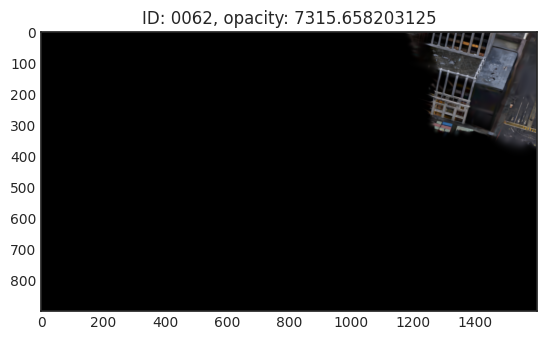

  4%|▎         | 63/1689 [00:14<09:51,  2.75it/s]

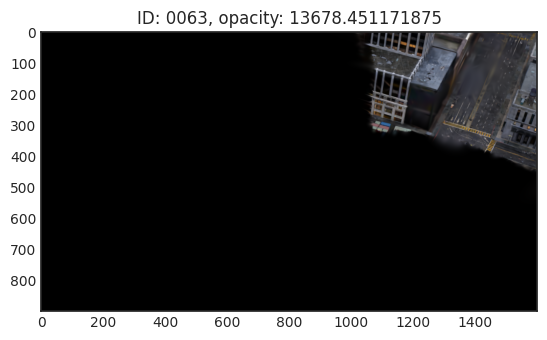

  4%|▍         | 64/1689 [00:14<11:11,  2.42it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


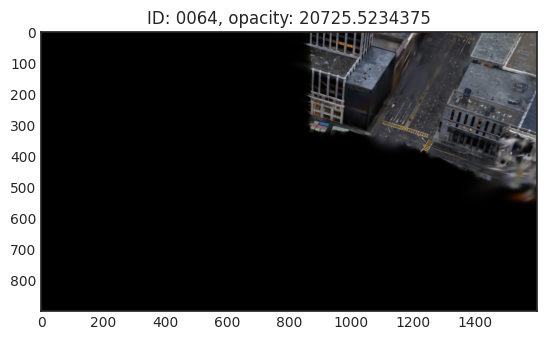

  4%|▍         | 64/1689 [00:15<06:33,  4.13it/s]


In [12]:
valid_num = 0
with torch.no_grad():
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    for idx in tqdm(range(len(views))):
        bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
        viewpoint_cam = loadCam(lp, id, views[idx], 1.0)

        render_pkg_block = render(viewpoint_cam, masked_gaussians, pp, background)
        image_block = render_pkg_block["render"]
        visibility_filter = render_pkg_block["visibility_filter"]
        total_opacity = render_pkg_block["geometry"][visibility_filter, 6].sum()
        image_block = image_block.cpu().numpy().transpose(1,2,0)

        if total_opacity > 4000:
            valid_num += 1
            ID = views[idx].image_path.split('/')[-1].split('.')[0]
            plt.figure()
            plt.imshow(image_block)
            plt.title(f'ID: {ID}, opacity: {total_opacity}')
            plt.show()
            if valid_num > 10:
                break